In [78]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from os.path import join

IRRELEVANT_COLUMNS = [
    'experiment_id', 'timestamp', 'time_this_iter_s',
    'time_total_s', 'pid', 'hostname', 'node_ip', 'config',
    'time_since_restore', 'timesteps_since_restore',
    'iterations_since_restore', 'perf', 'sampler_perf',
    'num_healthy_workers'
]

In [79]:
def load_and_trim_df(path: str) -> pd.DataFrame:
    split_path = path.split(os.sep)
    trainer_type, intersection = split_path[2:4]
    df = pd.read_csv(path)
    if "unranked" in path:
        df["ranked"] = ["unranked"] * len(df)
    else:
        df["ranked"] = ["ranked"] * len(df)
    df["trainer_type"] = [trainer_type] * len(df)
    df["intersection"] = [intersection] * len(df)
    df.drop(labels=IRRELEVANT_COLUMNS, inplace=True, axis=1)
    return df

In [80]:
def load_data(prefix: str=None) -> pd.DataFrame:
    if prefix is None:
        prefix = ""
    elif prefix[-1] != "_":
        prefix = prefix + "_"

    fedrl_dfs = [
        load_and_trim_df(join("out", "data", "FedRL", "grid-3x3", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "FedRL", "grid-5x5", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "FedRL", "double", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "FedRL", "grid-3x3", f"{prefix}ranked.csv")),
        load_and_trim_df(join("out", "data", "FedRL", "grid-5x5", f"{prefix}ranked.csv")),
        load_and_trim_df(join("out", "data", "FedRL", "double", f"{prefix}ranked.csv")),
    ]

    marl_dfs = [
        load_and_trim_df(join("out", "data", "MARL", "grid-3x3", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "MARL", "grid-5x5", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "MARL", "double", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "MARL", "grid-3x3", f"{prefix}ranked.csv")),
        load_and_trim_df(join("out", "data", "MARL", "grid-5x5", f"{prefix}ranked.csv")),
        load_and_trim_df(join("out", "data", "MARL", "double", f"{prefix}ranked.csv")),
    ]

    sarl_dfs = [
        load_and_trim_df(join("out", "data", "SARL", "grid-3x3", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "SARL", "grid-5x5", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "SARL", "double", f"{prefix}unranked.csv")),
        load_and_trim_df(join("out", "data", "SARL", "grid-3x3", f"{prefix}ranked.csv")),
        load_and_trim_df(join("out", "data", "SARL", "grid-5x5", f"{prefix}ranked.csv")),
        load_and_trim_df(join("out", "data", "SARL", "double", f"{prefix}ranked.csv")),
    ]

    df = pd.concat(fedrl_dfs + marl_dfs + sarl_dfs)
    return df

# df = load_data(prefix="dummy")
df = load_data()
print(f"Data Columns: {df.columns}\n")
df.head()

Data Columns: Index(['Unnamed: 0', 'round', 'trainer', 'policy', 'fed_round',
       'episode_reward_max', 'episode_reward_min', 'episode_reward_mean',
       'episode_len_mean', 'episode_media', 'episodes_this_iter',
       'policy_reward_min', 'policy_reward_max', 'policy_reward_mean',
       'custom_metrics', 'hist_stats', 'off_policy_estimator',
       'timesteps_total', 'agent_timesteps_total', 'timers', 'info', 'done',
       'episodes_total', 'training_iteration', 'date', 'callback_ok', 'ranked',
       'trainer_type', 'intersection'],
      dtype='object')



,Unnamed: 0,round,trainer,policy,fed_round,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episode_media,...,timers,info,done,episodes_total,training_iteration,date,callback_ok,ranked,trainer_type,intersection
0,0,0,FedRL,A0,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,"{'sample_time_ms': 225444.054, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3
1,1,0,FedRL,A1,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,"{'sample_time_ms': 225444.054, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3
2,2,0,FedRL,A2,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,"{'sample_time_ms': 225444.054, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3
3,3,0,FedRL,B0,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,"{'sample_time_ms': 225444.054, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3
4,4,0,FedRL,B1,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,"{'sample_time_ms': 225444.054, 'sample_through...","{'learner': defaultdict(<class 'dict'>, {'A0':...",False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3


In [81]:
# print(str(list(df["policy_reward_mean"])))

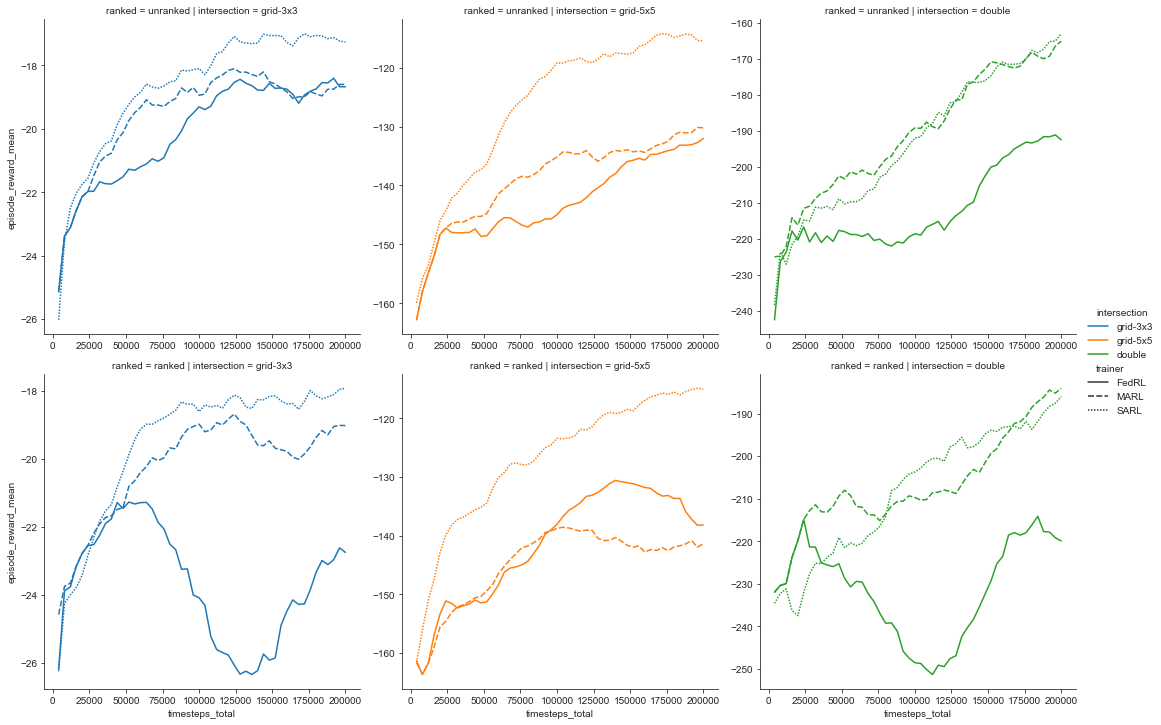

In [82]:
sns.relplot(
    data=df,#.query("trainer != 'FedRL'"), 
    kind="line", 
    x="timesteps_total", 
    y="episode_reward_mean", 
    style="trainer", 
    hue="intersection", 
    col="intersection",
    row="ranked",
    facet_kws={"sharey": False, "sharex": False},
    ci=None
)
plt.show()

In [83]:
import ast

TYPE_SPLITTER = "___"
COMM_TYPES = set(['edge_to_tls_action_comms', 'edge_to_tls_policy_comms', 'edge_to_tls_rank_comms', 
                  'tls_to_edge_obs_comms', 'tls_to_edge_policy_comms', 'veh_to_tls_info_comms'])
FED_COMM_TYPES = set(['edge_to_tls_policy_comms', 'tls_to_edge_policy_comms'])

def sum_comm_cost(data, comm_type, fed_round: bool=False):
    assert comm_type in COMM_TYPES
    data = ast.literal_eval(data)
    for key in data:
        if fed_round and comm_type in FED_COMM_TYPES:
            return 1
        if key.startswith(comm_type):
            # print(f"comm_type={comm_type}, key={key}")
            return data[key]
    raise ValueError("Invalid communication type.")
    # return sum(data.values())

comm_dfs = []
for comm_type in COMM_TYPES:
    temp_df = df.copy()
    temp_df["comm_cost"] = temp_df.apply(lambda row: sum_comm_cost(row["custom_metrics"], comm_type, row["fed_round"] and row["trainer"] == "FedRL"), axis=1)
    temp_df["comm_type"] = [comm_type] * len(temp_df)
    comm_dfs.append(temp_df)

temp_df = df.copy()
temp_df["comm_cost"] = sum(_df["comm_cost"] for _df in comm_dfs)
temp_df["comm_type"] = ["total_comm"] * len(temp_df)
comm_dfs.append(temp_df)
# comm_df["custom_metrics"] = comm_df.apply(lambda row: sum_comm_cost(row["custom_metrics"]), axis=1)

comm_df = pd.concat(comm_dfs)
comm_df.head()

,Unnamed: 0,round,trainer,policy,fed_round,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episode_media,...,done,episodes_total,training_iteration,date,callback_ok,ranked,trainer_type,intersection,comm_cost,comm_type
0,0,0,FedRL,A0,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3,5299.222222,veh_to_tls_info_comms
1,1,0,FedRL,A1,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3,5299.222222,veh_to_tls_info_comms
2,2,0,FedRL,A2,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3,5299.222222,veh_to_tls_info_comms
3,3,0,FedRL,B0,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3,5299.222222,veh_to_tls_info_comms
4,4,0,FedRL,B1,False,-16.588314,-32.184977,-25.142652,433.555556,{},...,False,9,1,2021-09-20_20-57-09,True,unranked,FedRL,grid-3x3,5299.222222,veh_to_tls_info_comms


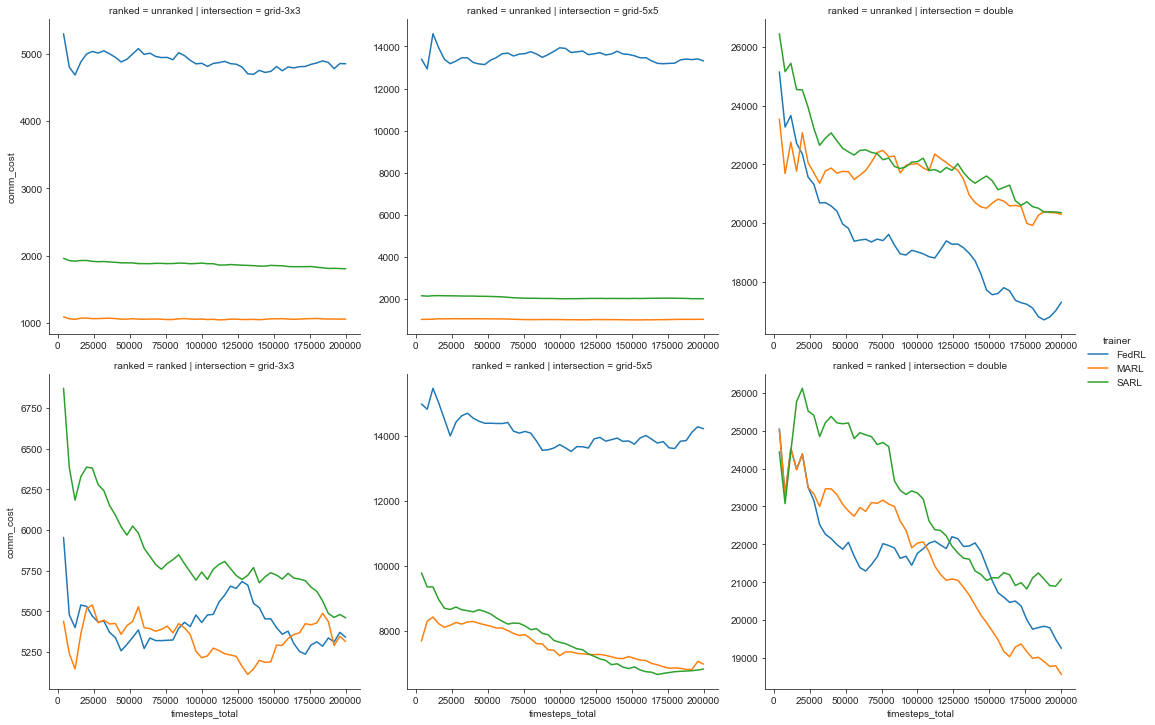

In [90]:
sns.relplot(
    kind="line",
    data=comm_df.query("comm_type == 'total_comm'"),
    x="timesteps_total",
    y="comm_cost",
    hue="trainer",
    row="ranked", 
    col="intersection",
    ci=None,
    facet_kws={"sharex": False, "sharey": False}
)
plt.show()

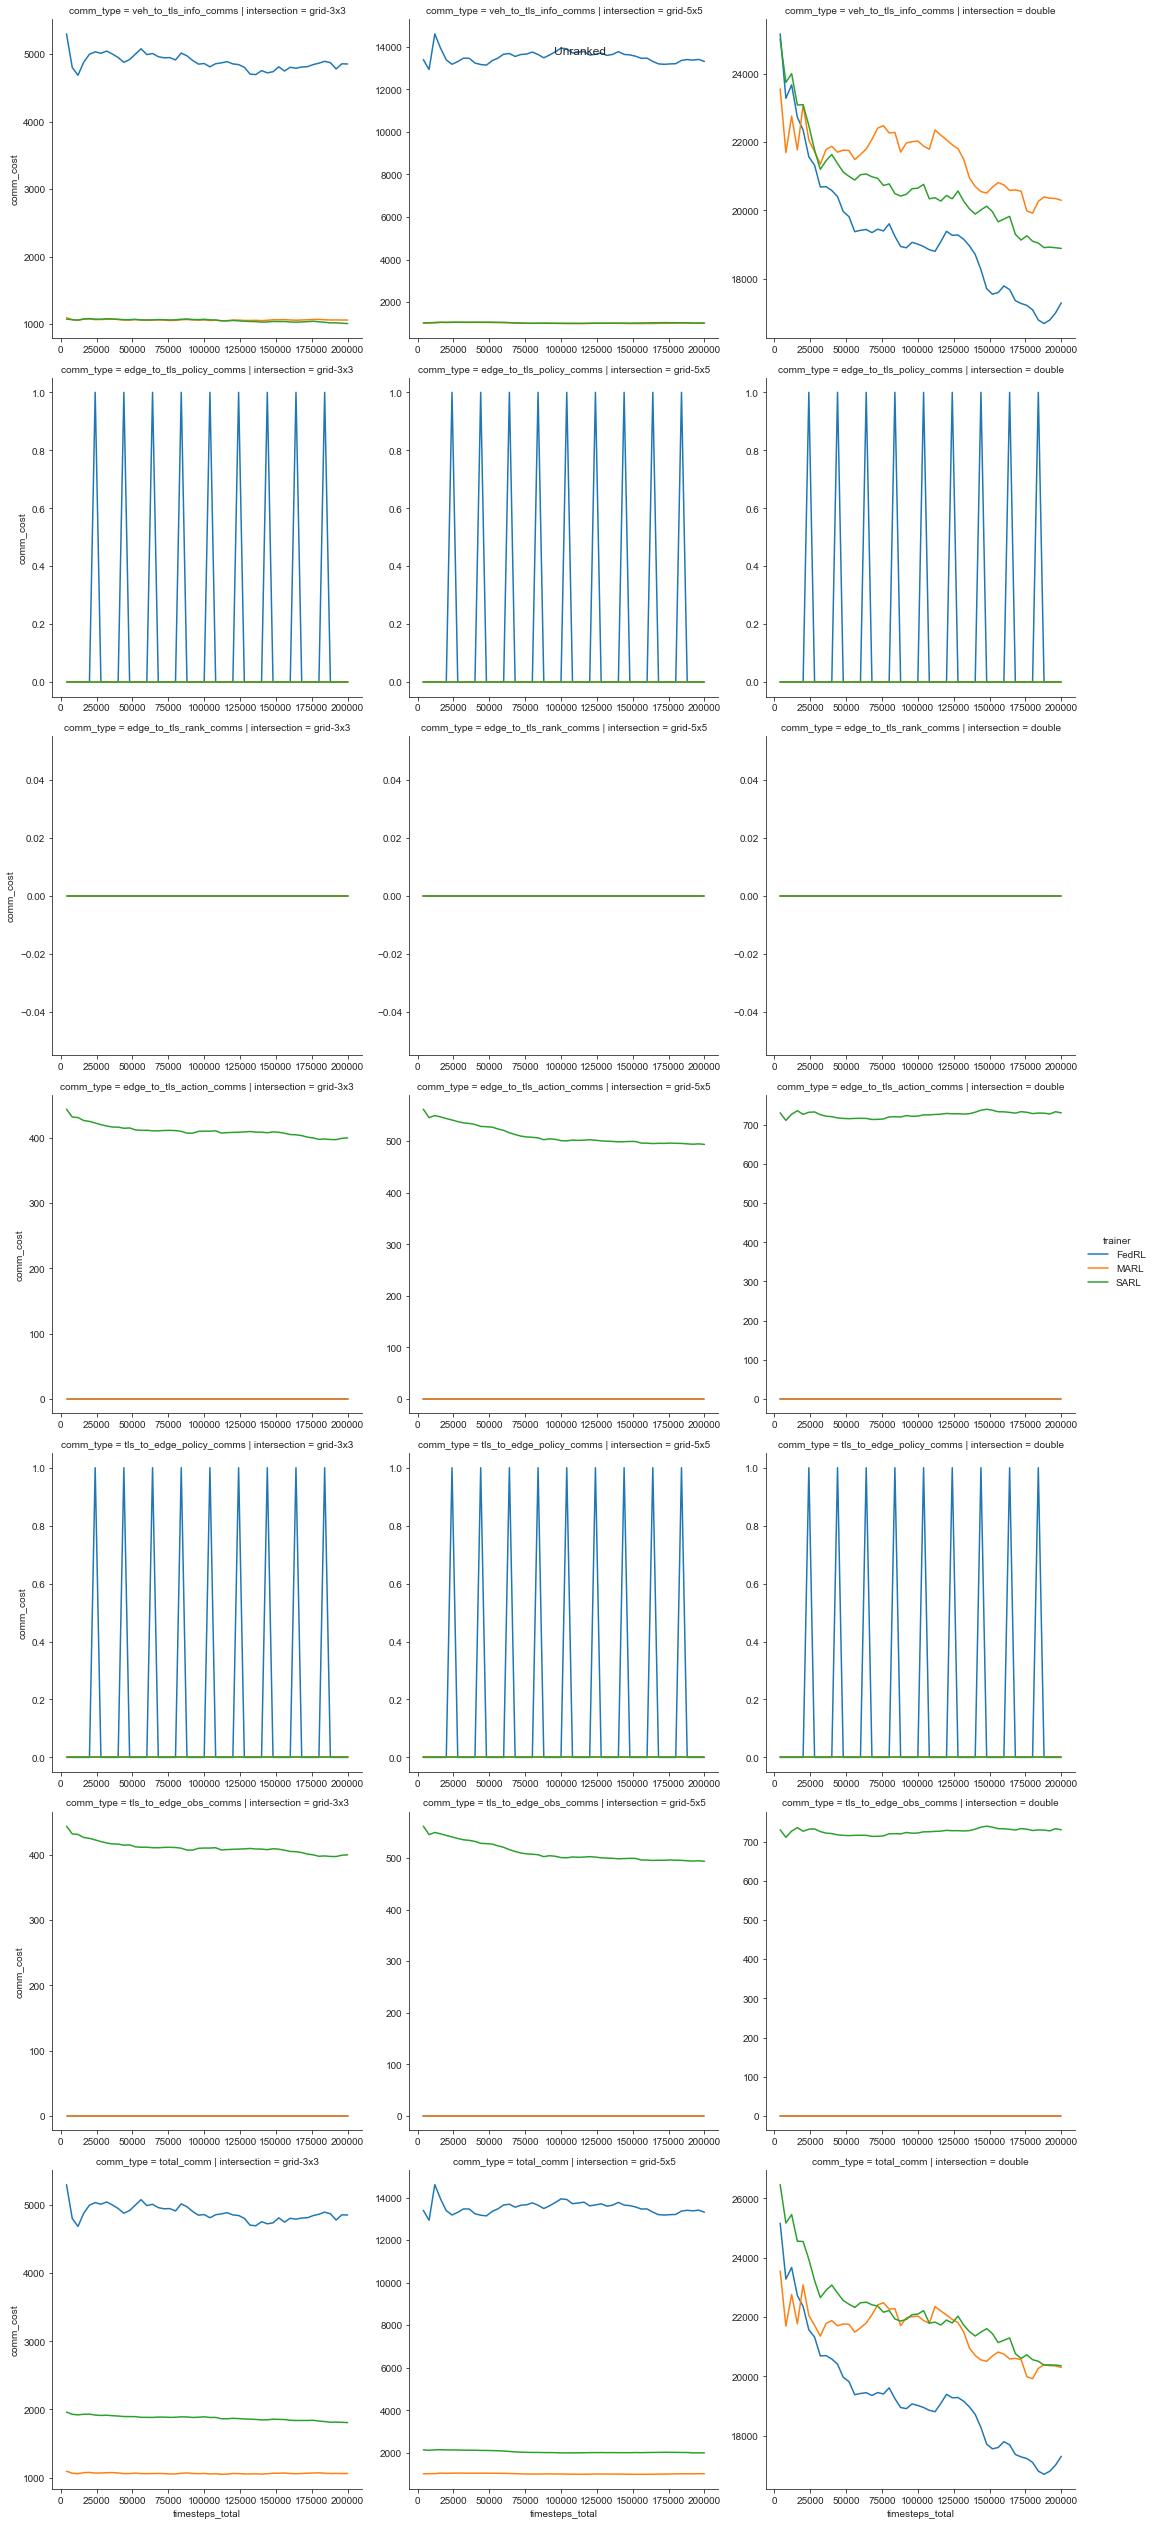

In [91]:
ranked_type = "unranked"
sns.relplot(
    kind="line",
    data=comm_df.query(f"ranked == '{ranked_type}'"),
    x="timesteps_total",
    y="comm_cost",
    hue="trainer",
    # style="comm_type",
    row="comm_type",
    col="intersection",
    facet_kws={"sharex": False, "sharey": False},
    ci=None
)#.set(yscale="log")
plt.suptitle(ranked_type.title())
plt.show()

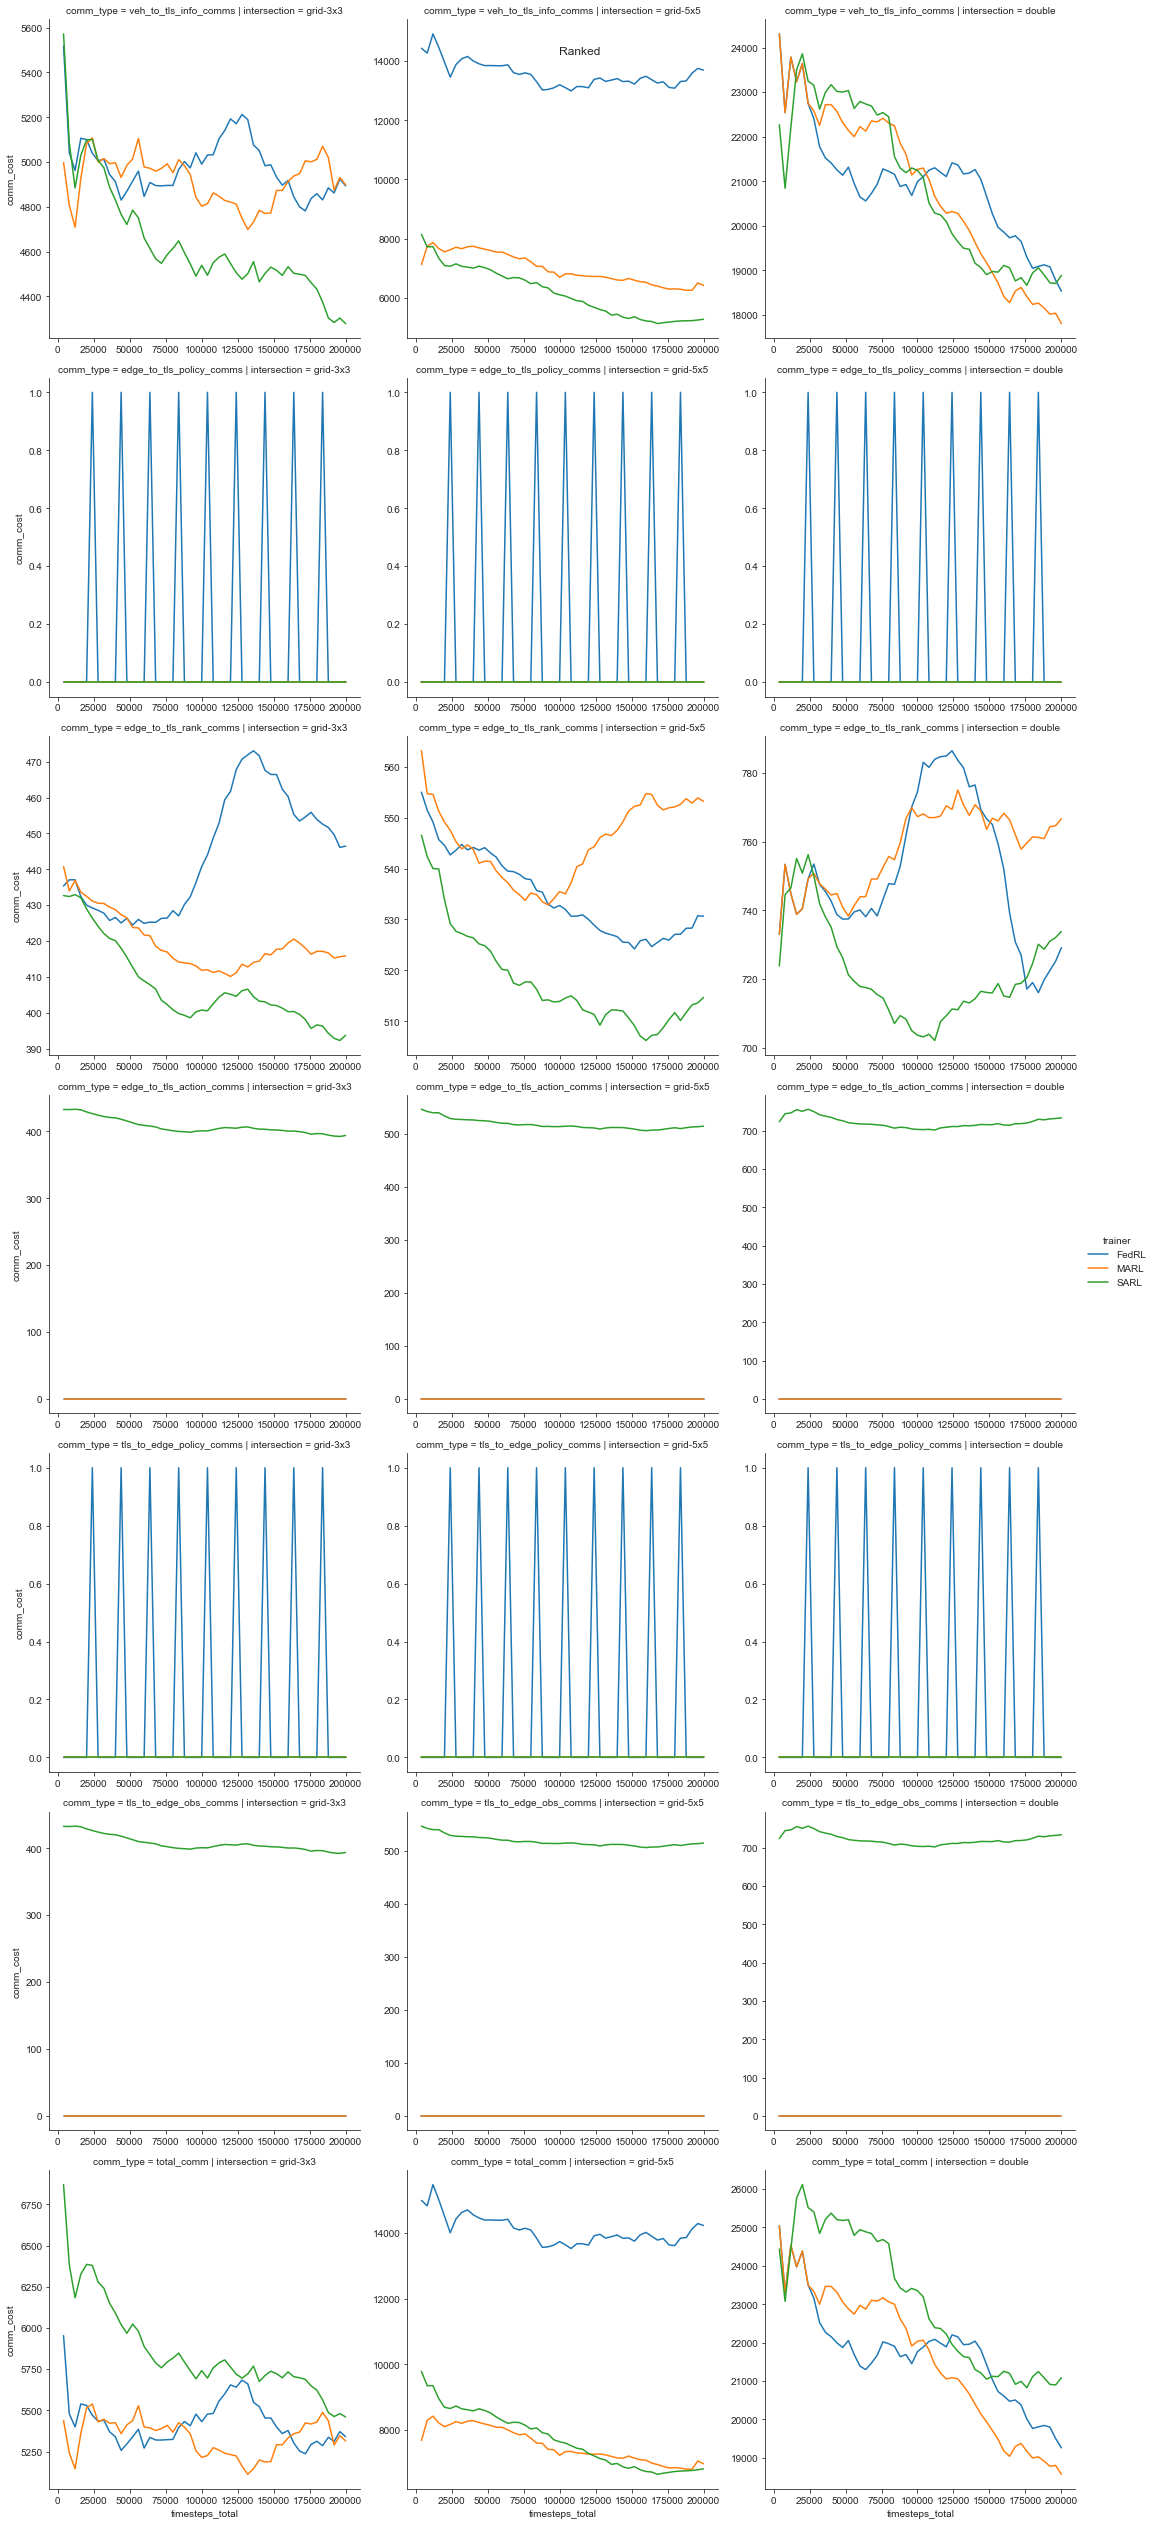

In [92]:
ranked_type = "ranked"
sns.relplot(
    kind="line",
    data=comm_df.query(f"ranked == '{ranked_type}'"),
    x="timesteps_total",
    y="comm_cost",
    hue="trainer",
    # style="comm_type",
    row="comm_type",
    col="intersection",
    facet_kws={"sharex": False, "sharey": False},
    ci=None
)#.set(yscale="log")
plt.suptitle(ranked_type.title())
plt.show()

In [87]:
df.columns

Index(['Unnamed: 0', 'round', 'trainer', 'policy', 'fed_round',
       'episode_reward_max', 'episode_reward_min', 'episode_reward_mean',
       'episode_len_mean', 'episode_media', 'episodes_this_iter',
       'policy_reward_min', 'policy_reward_max', 'policy_reward_mean',
       'custom_metrics', 'hist_stats', 'off_policy_estimator',
       'timesteps_total', 'agent_timesteps_total', 'timers', 'info', 'done',
       'episodes_total', 'training_iteration', 'date', 'callback_ok', 'ranked',
       'trainer_type', 'intersection'],
      dtype='object')

In [88]:
df.groupby(["trainer", "intersection"]).median()

Unnamed: 0  round  episode_reward_max  \
trainer intersection                                          
FedRL   double              74.5   24.5         -140.868972   
        grid-3x3           249.5   24.5          -14.229699   
        grid-5x5           649.5   24.5         -113.514847   
MARL    double              74.5   24.5         -133.041618   
        grid-3x3           249.5   24.5          -13.639499   
        grid-5x5           649.5   24.5         -115.868885   
SARL    double              49.5   24.5         -121.598958   
        grid-3x3            49.5   24.5          -13.314151   
        grid-5x5            49.5   24.5          -98.261201   

                      episode_reward_min  episode_reward_mean  \
trainer intersection                                            
FedRL   double               -343.910783          -220.264984   
        grid-3x3              -32.221221           -21.752980   
        grid-5x5             -176.367825          -142.456092   
MARL    double               -322.339072          -202.218088   
        grid-3x3              -30.208088           -19.293293   
        grid-5x5             -180.495686          -140.905638   
SARL    double               -294.817467          -200.084908   
        grid-3x3              -27.824967           -18.408161   
        grid-5x5             -159.816885          -121.989652   

                      episode_len_mean  episodes_this_iter  timesteps_total  \
trainer intersection                                                          
FedRL   double              731.051923                 5.0         102000.0   
        grid-3x3            426.693548                 9.0         102000.0   
        grid-5x5            536.395000                 8.0         102000.0   
MARL    double              738.271429                 6.0         102000.0   
        grid-3x3            414.080000                10.0         102000.0   
        grid-5x5            537.115094                 7.0         102000.0   
SARL    double              723.645000                 6.0         102000.0   
        grid-3x3            407.840000                10.0         102000.0   
        grid-5x5            512.190000                 8.0         102000.0   

                      agent_timesteps_total   done  episodes_total  \
trainer intersection                                                 
FedRL   double                     204000.0  False           135.5   
        grid-3x3                   918000.0  False           237.5   
        grid-5x5                  2550000.0  False           188.5   
MARL    double                     204000.0  False           139.5   
        grid-3x3                   918000.0  False           244.5   
        grid-5x5                  2550000.0  False           189.5   
SARL    double                     204000.0  False           141.0   
        grid-3x3                   918000.0  False           247.5   
        grid-5x5                  2550000.0  False           197.0   

                      training_iteration  callback_ok  
trainer intersection                                   
FedRL   double                      25.5         True  
        grid-3x3                    25.5         True  
        grid-5x5                    25.5         True  
MARL    double                      25.5         True  
        grid-3x3                    25.5         True  
        grid-5x5                    25.5         True  
SARL    double                      25.5         True  
        grid-3x3                    25.5         True  
        grid-5x5                    25.5         True

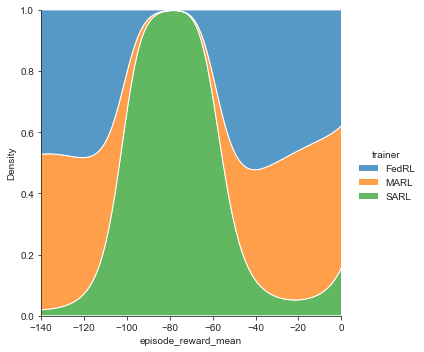

In [89]:
import seaborn as sns

sns.set_style("ticks")

sns.displot(data=df, kind="kde", hue="trainer", x="episode_reward_mean", multiple="fill")
plt.xlim(-140, 0)
plt.show()